import libraries

In [1]:
import tensorflow as tf  # Only used as a asource of MNIST data
import requests
import numpy as np
import matplotlib.pyplot as plt

Get MNIST data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Select random image from the test part of MNIST

Text(0.5, 1.0, "Digit '6'")

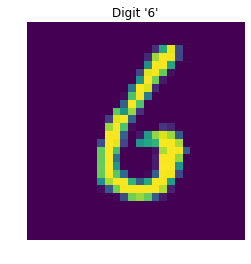

In [3]:
idx = np.random.choice(range(x_test.shape[0]))
x = x_test[idx]
plt.imshow(x)
plt.axis('off')
plt.title(f"Digit '{y_test[idx]}'")

Specify the inference link to the hydrosphere.io

In [4]:
# service_link = "https://dev.k8s.hydrosphere.io/gateway/application/mnist-app"
service_link = "http://fc13d681.serving.odsc.k8s.hydrosphere.io/gateway/application/mnist_app"

Check the inference service

In [5]:
response = requests.post(url=service_link, json={"imgs": [x.tolist()]})
predicted_probas = np.array(response.json()["probabilities"])
f"Predicted label is {predicted_probas.argmax()}"

'Predicted label is 6'

In [6]:
print("Probabilities vector", np.array(response.json()['probabilities']))

Probabilities vector [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Specify the link to the RISE image interpretability service

In [7]:
rise_link = "http://0.0.0.0:5000/rise" 

In [10]:
rise_config = {"number_of_masks":300,
               "mask_granularity":3,
               "mask_density":0.4,
               "input_size": [28,28],
               "single_channel": True,
               }

In [28]:
response = requests.post(url=rise_link, json={"image": x.tolist(),
                                              "config": rise_config,
                                              "application_name":"mnist_app"})  # Send image in json
print(response)
result_location = response.headers['Location']
print(result_location)

<Response [202]>
http://0.0.0.0:5000/status/rise/11e38459-296e-4316-b9b8-6a3aa83b228d


Poll results

In [12]:
# First status
response = requests.get(result_location)
print(response.text)

{
  "result": "5cee587e46747810779f3fc1", 
  "state": "SUCCESS"
}



In [13]:
# Second status with dynamic progress
response = requests.get(result_location)
print(response.text)

{
  "result": "5cee587e46747810779f3fc1", 
  "state": "SUCCESS"
}



In [14]:
# Last status with id of mongodb entry
response = requests.get(result_location)
result_id = response.json()['result']
print(response.text)

{
  "result": "5cee587e46747810779f3fc1", 
  "state": "SUCCESS"
}



Retrieve results from MongoDB

In [15]:
import pymongo 
client = pymongo.MongoClient()

In [16]:
from bson.objectid import ObjectId
explanation = client['root_cause'].rise_explanations.find_one({"_id":ObjectId(result_id)})

In [17]:
# Examine the keys
explanation.keys()

dict_keys(['_id', 'image', 'config', 'application_name', 'created_at', 'started_at', 'completed_at', 'result'])

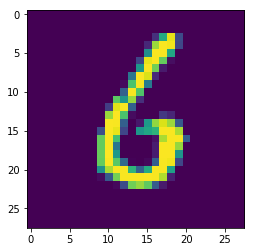

In [18]:
image = np.array(explanation['image'])
plt.imshow(image)

Reconstruct the saliency map tensor from bstring. The result cllection of masks is of shape (number of classes; width; height). It contains a sailency map for each output class.

In [21]:
explanation['result']["masks"].decode("utf-8", 'ignore')

'r\x06a?p:y(Qg?OG\x15n?Ve\n\x19mr?Mq[u?E\u061d1y?w?|?٦"\x7f?A2?uS]?=)t\x0e?ۜ~!?LѤ?V~X)?碻\t׆?\x16?r?f\x07?GC ?8q\x1aWq~?&(z?\x0fi\x19v?i~\x052s?Z?\x05o?L&\x1eKg?\x01WE`?*fS?D0L+\x01R?\x16Jo\x05S?i:1h?\x03hl?\x05Nq?6W&t?k\x1c\x1bv?Uڧzy?\x011J\x0c|?lᝄ\x7f?k\x17.?g?Շ,T\x05?\tm\x1frq?fd+ ?#m\x15\x14?{F_X+?A\x07f?yG\r?aEк\x7f?\x031|?\x0fT;x?Z%K-u?Yhq?WyCl?ݫ\x19e?}yȼ]?4\\;\x08\x07AR?>ӔP?\x16\x10Q?}G\x1elo?c\x17u{q?,\rs?\x1c[\x05v?\x0c\x08=x?8uz??hF|?\x03N\x13~?ccq\x16?ı{\x18#?&w/ǂ?<f<?YZ?qﺈ,?k/\x18`G?\x7fު?Vp]\x0e?"6 8|?\x05y?j\x13qv?QeEs?Vw&p?\x125g\x10j?\x086;c?Fn*[?ͭ*P?L-|\x04N?ݸ3kP?\x1b`Ss?<17\x13t?1\\^Lv?T\x0f,\x00w?\x0cM{}y?yEDC\x16{?0R|?\x05]G~?^\'\'\x7f?[(Id?\t~?ݳG\x06U?/[\x1fȓ?"\x07D?Jgc?/\x02\x15\x7f?P`Z|?\x0cz?\x1b#w?\'Sy*;t?\x07K^q?B\t\x17\x1am?w:xg?ʄa?}HhX?\x00BM?a\t\x03QߞK?f\x02^ZM?1\x02v?0!/w?rS\x14\'x?K6Py?#\x19pzz?4Ƥ{?\x1eί|?\x1b}?\x17rw"~?\x124D]L\x7f?\x07!;J?\x05e\x14ƀ?f96̀?YTo]?eY8\x18~?\x15|lf|?Wy?oC5w?\x14t?\\\x0b\x04r?#9Qn?U$"i?~rd?\\\x1eͳt_?W\x0eU?M*JJ?R%H?\x18\x04J?WH

In [22]:
saliency_maps = np.frombuffer(explanation['result']['masks']).reshape(explanation['result']['shape'])
saliency_maps.shape  # For some mystic reason this version of mnist-app produces probabilites vector of 20-dim

(20, 28, 28)

Visualize results

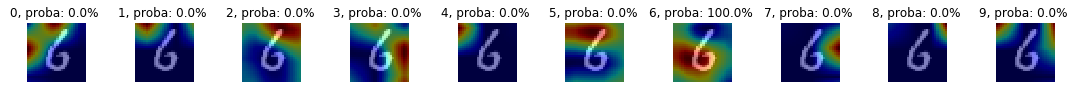

In [23]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(15, 6)
for i in range(10):
    axes[i].set_title(f"{i}, proba: {predicted_probas[0][i]*100}% ")
    axes[i].axis('off')
    axes[i].imshow(x, cmap="gray")
    axes[i].imshow(saliency_maps[i], cmap='jet', alpha=0.5)
    
plt.tight_layout()
plt.show()